#  Analysis of C++ code output and plot quantities: force-velocity relation from average trajectories

In [92]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
import os
from datetime import datetime
import yaml

In [155]:
def multiindexe_average_trajectories_df(df_to_multiindex,cargo_min,cargo_max,numbers_points):
    #==========================================================================================================
    # this function requirets 4 arguments. all are mandatory:
    # - df_to_multiindex: the pandas data frame which contains all average trajectories;
    # - cargo_min: is the inferior value of external cargo interval [cargoMin,cargoMax].
    #In C++ code the interval values are indexed in vecotr order 0:CargoMin,....,numbers_points-1:CargoMax.
    #the duration of one time period of color noise function
    # - cargo_max: is the superior value of external cargo interval [cargoMin,cargoMax].
    #- numbers_points: is the length of the interval [cargoMin,cargoMax].
    #==========================================================================================================    
    
    # here we define the additional Data Frame with value of external load f_ext, each line corresponds to cargo index
    df_external_load = pd.DataFrame(np.linspace(cargo_min,cargo_max,numbers_points),columns= ['f_ext'])
    df_external_load['cargo'] = df_external_load.index
    df_to_multiindex = df_to_multiindex.merge(df_external_load, on = ['cargo'],how = 'left')

    # we identify the number of blocks and external load points
    cargo_size = len(df_to_multiindex['cargo'].unique())
    block_numbers = len(df_to_multiindex['block'].unique())

    # we constract the grid of multiindex
    tuples = list(zip(df_raw['cargo'],df_raw['block']))

    # we reindex the data frame
    df_to_multiindex.index  = pd.MultiIndex.from_tuples(tuples, names=["cargo", "block"])
    df_to_multiindex.dropna(how='all', inplace = True)
    return df_to_multiindex

def matrix_reduce_block_average_velocity_from_trajectory(df_to_reduce, block, period_duration,dt, dt_save, number_periods, number_periods_to_relax):
    #==========================================================================================================
    # this function requirets 5 arguments. all are mandatory:
    # - df_to_reduce: multiindex data frame based on standard output with average trajectories;
    # - block: is the block index {0,1,2, ...N} for which you want extract the froce-velocity relation,
    # - period_duration: usually it's just 'characteristicTimeColorNoise',
    #the duration of one time period of color noise function
    # - time_step: is the time step between two succesive saved values of block position
    #according the coordinates {X,Y,Z}. Usually: dt* dtSave
    #number_periods: is the integer number. The total number of color noise time periods imposed by simulation.
    #This number fixe the duration of simulation.  
    #==========================================================================================================
    time_step = dt*dt_save
    start_last_period = int(number_periods - number_periods_to_relax-1) *int(np.floor(period_duration / time_step))
    cargo_size = len(df_to_reduce['cargo'].unique())
    number_blocks = len(df_to_reduce['block'].unique())
    df_to_reduce = df_to_reduce.loc[:,['step',	'meanX','meanY','meanZ','f_ext']]
    if number_blocks == 1:
        columns_name_final_0 = ['f_ext',
                              'mean_velocity_x_full_trajectory',
                              'mean_velocity_y_full_trajectory',
                              'mean_velocity_z_full_trajectory']
        columns_name_final_1 = ['f_ext',
                              'mean_velocity_x_all_paths_last_period',
                              'mean_velocity_y_all_paths_last_period',
                              'mean_velocity_z_all_paths_last_period']
    else:
        columns_name_final_0 = ['f_ext',
                              'mean_velocity_x_'+str(block)+'_full_trajectory',
                              'mean_velocity_y_'+str(block)+'_full_trajectory',
                              'mean_velocity_z_'+str(block)+'_full_trajectory']
        columns_name_final_1 = ['f_ext',
                              'mean_velocity_x_'+str(block)+'_all_paths_last_period',
                              'mean_velocity_y_'+str(block)+'_all_paths_last_period',
                              'mean_velocity_z_'+str(block)+'_all_paths_last_period']
    my_array_0 = []
    my_array_1 = []
    columns_name = {'meanX': 'mean_v_x',
                    'meanY': 'mean_v_y',
                    'meanZ': 'mean_v_z'}
    temporal_df_to_reduce = df_to_reduce.copy()
    temporal_df_to_reduce = temporal_df_to_reduce.rename(columns=columns_name)
    for cargo_enum in range(cargo_size):
        f_ext_temporal = temporal_df_to_reduce.loc[cargo_enum,block]['f_ext'].unique()[0]
        temporal_df = temporal_df_to_reduce.loc[cargo_enum,block][['mean_v_x','mean_v_y','mean_v_z']]
        last_period_data = temporal_df.reset_index(drop=True).iloc[start_last_period:]
        
        v_temporal = (temporal_df.diff()/time_step).dropna()
        v_period_temporal = (last_period_data.diff()/time_step).dropna()
        
        v_array = np.squeeze((v_temporal.sum()/(v_temporal.shape[0])).values).flatten()
        v_period_array = np.squeeze((v_period_temporal.sum()/v_period_temporal.shape[0])).values.flatten()
      
        v_array = np.insert(v_array,0,f_ext_temporal)
        v_period_array = np.insert(v_period_array,0,f_ext_temporal)
        my_array_0.append(v_array)
        my_array_1.append(v_period_array)
    df_0 = pd.DataFrame(my_array_0, columns = columns_name_final_0) 
    df_1 = pd.DataFrame(my_array_1, columns = columns_name_final_1)
    return df_0.merge(df_1, on ='f_ext', how= 'left')

def reconstruct_generic_force_velocity_data_frame_for_all_blocks(df_to_reduce, block, period_duration, time_step, number_periods,output_path=''):
    number_blocks = len(df_to_reduce['block'].unique())
    #empty data frame
    for block in range(number_blocks):
         df_block = matrix_reduce_block_average_velocity_from_trajectory(df_to_reduce, block, period_duration, time_step, number_periods)
         if output_path!='':
            df_block.to_csv(os.path.join(output_path+'.csv'))
    return 1
        

def plot_generic_average_trajectories(df_to_plot,fig_width = 12,fig_higth=4.5):
    raw_figure = 0
    cargo_size= len(df_to_plot['cargo'].unique())
    block_numbers= len(df_to_plot['block'].unique())
    fig, ax = plt.subplots(block_numbers,2,figsize = (fig_width,block_numbers*fig_higth))
    linewidth_array = np.linspace(0.2,2.5,len(range(cargo_size)))
    for cargo_enum,line_w in zip(range(cargo_size),linewidth_array):
        for blocks_enum in range(block_numbers):
            selected_data = df_to_plot.loc[cargo_enum,blocks_enum]
            if block_numbers == 1:
                ax[0].plot(selected_data['step']*dt*dt_save,selected_data['meanZ'],'-b',linewidth = line_w)
                ax[0].plot(selected_data['step']*dt*dt_save,selected_data['meanX'],'-r',linewidth = line_w)
                ax[0].set(xlabel = r'$time$',ylabel = r'$\langle x\rangle$,$\langle z\rangle$')
                ax[1].plot(selected_data['step']*dt*dt_save,selected_data['meanY'],'-k',linewidth = line_w)
                ax[1].set(xlabel = r'$time$',ylabel = r'$\langle y\rangle$')
            else:
                ax[blocks_enum,0].plot(selected_data['step']*dt*dt_save,selected_data['meanZ'],'-b',linewidth = line_w)
                ax[blocks_enum,0].plot(selected_data['step']*dt*dt_save,selected_data['meanX'],'-r',linewidth = line_w)
                ax[blocks_enum,0].set(xlabel = r'$time$',ylabel = r'$\langle x\rangle$,$\langle z\rangle$')
                at = AnchoredText(r'Block '+str(blocks_enum), prop=dict(size=10), frameon=False, loc='upper left')
                ax[blocks_enum,0].add_artist(at)
                ax[blocks_enum,1].plot(selected_data['step']*dt*dt_save,selected_data['meanY'],'-k',linewidth = line_w)
                ax[blocks_enum,1].set(xlabel = r'$time$',ylabel = r'$\langle y\rangle$')               
    plt.show(fig)
    
    

In [158]:
now = datetime.now().strftime("%Y%m%d-%H%M%S")
print('date time: ',now)
cur_dir = os.getcwd()
print('current directory: ',cur_dir)
# you can define here your prefered folder path for figiures saveguard
FIGURES_PATH = os.path.join(cur_dir,'figures')
print('FIGURES_PATH: ',FIGURES_PATH)
# you have to precise where data are stored, for exemple
DATA_PATH = os.path.join(cur_dir,'src','data')
print('DATA_PATH: ',DATA_PATH)
#create_folder_if_not_exists(FIGURES_PATH)

date time:  20220526-082946
current directory:  d:\LabIREM\codes\c++\y_ps_ratchet\BMTlab_Y_ratchet_parallel_soft_device
FIGURES_PATH:  d:\LabIREM\codes\c++\y_ps_ratchet\BMTlab_Y_ratchet_parallel_soft_device\figures
DATA_PATH:  d:\LabIREM\codes\c++\y_ps_ratchet\BMTlab_Y_ratchet_parallel_soft_device\src\data


## the mandatory parameters take in C++ ***config*** file:
- dt, simulation time step; ***dt*** in c++ config file
- dt_save, ***dtSave*** in c++ config file
- cargo_min, external_load characteristics ***cargoMin*** in c++ config file
- cargo_max, external_load characteristics ***cargoMax*** in c++ config file
- numbers_points, is the ***numberPoints*** number of points computed on interval ***{cargoMin,cargoMax}***
- characteristicTimeColorNoise
- number_periods, is the ***numberPeriodsTotalDuration*** in C++ config file

In [179]:
# for exemple:
config_dict = yaml.load(open(os.path.join(os.getcwd(),'src','Config.json'),'r'),Loader=yaml.FullLoader)
dt=config_dict['numerics'][0]['dt']
dt_save = config_dict['numerics'][1]['dtSave']
number_periods = config_dict['numerics'][3]['numberPeriodsTotalDuration']
number_periods_to_relax = config_dict['numerics'][4]['numberPeriodsToRelax']
cargo_min = config_dict['external_load'][0]['cargoMin']
cargo_max = config_dict['external_load'][1]['cargoMax']
numbers_points = config_dict['external_load'][2]['numberPoints']
characteristicTimeColorNoise = config_dict['color_noise_properties'][1]['characteristicTimeColorNoise']
state_block_number = config_dict['state'][0]['blockNumber']


## the usual procedure to follow:
1. read the average trajectories output CSV file as Pandas Data Frame
2. defenes multiindex {cargo,block} of obtained Data Frame in the step 1 and add the 'f_ext' column in Data Frame
3. reduce the Data Frame for wanted block index to obtain force-velocity relation. Note what in steady state regime all block should provides the similar force-velocity relation.

### 1step. We read CSV as pandas Data Frame

In [185]:
# here we define the file to read
filename = "OUT0"
df_raw = pd.read_csv(os.path.join(DATA_PATH,filename), sep=';')

In [186]:
df_raw

,cargo,block,step,meanX,meanY,meanZ
0,0,0,0,-0.793046,-1.38038,-7.20610
1,0,0,1,-0.793173,-1.37785,-7.19973
2,0,0,2,-0.793328,-1.37338,-7.19481
3,0,0,3,-0.792781,-1.37381,-7.19097
4,0,0,4,-0.794495,-1.37063,-7.18641
...,...,...,...,...,...,...
399975,19,0,19994,18.237400,2.52620,19.29160
399976,19,0,19995,18.237200,2.53515,19.29760
399977,19,0,19996,18.237600,2.54438,19.30640
399978,19,0,19997,18.236300,2.54734,19.31530


### 2. Multiindex the Data Frame

In [187]:
df_multiindexed = multiindexe_average_trajectories_df(df_raw,cargo_min,cargo_max,numbers_points)

### If you want, you can display the multiindex Data Frame content using the the generric figure, where one line for each block, on the left figure meanX, meanZ on the rigth - the meanY

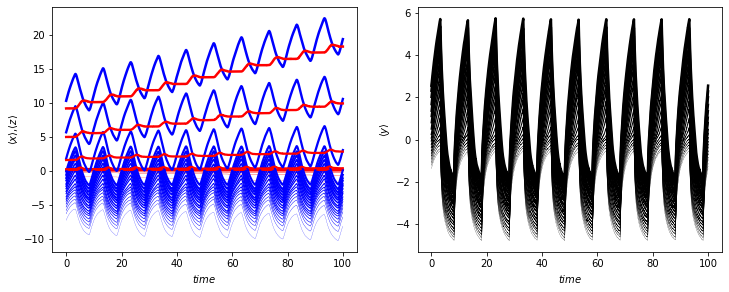

In [188]:
plot_generic_average_trajectories(df_multiindexed,fig_width = 12,fig_higth=4.5)                                                                                                                             

### 3. Force-velocity relation for wanted block 

we want extract force-velocity relation from generated average trajectories for the block index 0

In [189]:
block_index = 0

df_reduced = matrix_reduce_block_average_velocity_from_trajectory(df_multiindexed,
                                                                  block_index,
                                                                  characteristicTimeColorNoise,
                                                                  dt,dt_save,
                                                                  number_periods,number_periods_to_relax)

to view the content simply use (use option .head() for 5 first rows):

In [190]:
df_reduced

,f_ext,mean_velocity_x_full_trajectory,mean_velocity_y_full_trajectory,mean_velocity_z_full_trajectory,mean_velocity_x_all_paths_last_period,mean_velocity_y_all_paths_last_period,mean_velocity_z_all_paths_last_period
0,-4.000000,-0.008912,-0.000063,-0.008799,-0.007164,-0.001853,-0.010422
1,-3.784211,-0.004239,-0.000338,-0.004754,-0.000399,0.000003,-0.002556
2,-3.568421,-0.001654,-0.000480,-0.001898,-0.000889,-0.002992,-0.002119
3,-3.352632,-0.000687,-0.000183,-0.001410,0.000405,-0.002815,-0.004226
4,-3.136842,-0.000547,-0.000519,-0.001165,-0.000369,-0.002405,0.000493
5,-2.921053,-0.000003,-0.000225,-0.000580,-0.000083,0.000314,-0.002458
6,-2.705263,0.000060,-0.000137,-0.000114,0.000490,-0.001167,-0.001949
7,-2.489474,-0.000009,0.000065,-0.000182,-0.000104,0.001021,-0.000108
8,-2.273684,-0.000120,-0.000074,0.000064,0.000062,-0.000862,0.003025
9,-2.057895,-0.000029,-0.000279,-0.000550,-0.000233,-0.001898,-0.002107


you can plot the reslut using

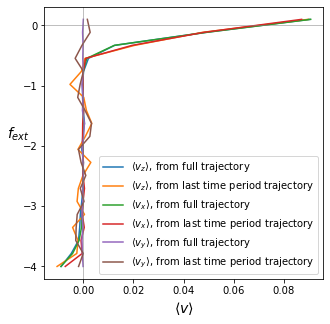

In [191]:
figure,ax = plt.subplots(1,figsize=(5,5))
if(state_block_number)==1:
    plt.plot(df_reduced.mean_velocity_z_full_trajectory,df_reduced.f_ext,label = r'$\langle v_{z}\rangle$, from full trajectory')
    plt.plot(df_reduced.mean_velocity_z_all_paths_last_period,df_reduced.f_ext,label = r'$\langle v_{z}\rangle$, from last time period trajectory')
    plt.plot(df_reduced.mean_velocity_x_full_trajectory,df_reduced.f_ext,label = r'$\langle v_{x}\rangle$, from full trajectory')
    plt.plot(df_reduced.mean_velocity_x_all_paths_last_period,df_reduced.f_ext,label = r'$\langle v_{x}\rangle$, from last time period trajectory')
    plt.plot(df_reduced.mean_velocity_y_full_trajectory,df_reduced.f_ext,label = r'$\langle v_{y}\rangle$, from full trajectory')
    plt.plot(df_reduced.mean_velocity_y_all_paths_last_period,df_reduced.f_ext,label = r'$\langle v_{y}\rangle$, from last time period trajectory')
else:
    plt.plot(df_reduced['mean_velocity_z_'+str(block_index)+'_full_trajectory'],df_reduced.f_ext,label = r'$\langle v_{z}\rangle$, from full trajectory')
    plt.plot(df_reduced['mean_velocity_z_'+str(block_index)+'_all_paths_last_period'],df_reduced.f_ext,label = r'$\langle v_{z}\rangle$, from last time period trajectory')
    plt.plot(df_reduced['mean_velocity_x_'+str(block_index)+'_full_trajectory'],df_reduced.f_ext,label = r'$\langle v_{x}\rangle$, from full trajectory')
    plt.plot(df_reduced['mean_velocity_x_'+str(block_index)+'_all_paths_last_period'],df_reduced.f_ext,label = r'$\langle v_{x}\rangle$, from last time period trajectory')
    plt.plot(df_reduced['mean_velocity_y_'+str(block_index)+'_full_trajectory'],df_reduced.f_ext,label = r'$\langle v_{y}\rangle$, from full trajectory')
    plt.plot(df_reduced['mean_velocity_y_'+str(block_index)+'_all_paths_last_period'],df_reduced.f_ext,label = r'$\langle v_{y}\rangle$, from last time period trajectory')    
ax.axhline(y=0.,linewidth = 0.5, color = 'gray')
ax.axvline(x=0.,linewidth = 0.5, color = 'gray')
ax.set_ylabel(r'$f_{ext}$', fontsize = 14, rotation = 0)
ax.set_xlabel(r'$\langle v\rangle$', fontsize = 14)
ax.legend(loc = 'best')
plt.show()